In [1]:
%load_ext autoreload
%autoreload 2

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Interactive Environment Generation

Cause I'm lazy, lets use [this pixel art tool](https://www.pixilart.com/draw#).

Follow these steps:

1. File -> New -> (height, width = 13, or whatever size you want but default minigrid is 15 x 15 with walls on all sides so 13 x 13)
2. Import the colour palette used: `00ff00,ff0000,0000ff,000000,ffffff`. On the bottom right ish you should see an import button: 

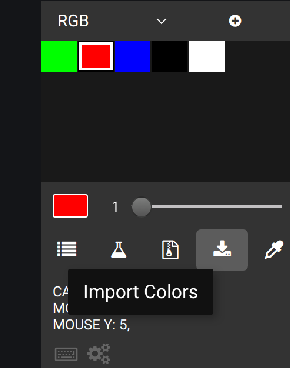

3. Draw your shit:
    - Blue: walls
    - Red: agent
    - Green: goal
    
4. Export your image as a png and then use it in this script

## Define creation classes (keep scrolling down)

In [2]:
AGENT = (245, 0, 0) # red
GOAL = (0, 245, 0)  # green
WALL = (0, 0, 245)  # blue


class AdversarialEnvCreator:
    def __init__(self, 
                 agent_colour: tuple = AGENT, 
                 goal_colour: tuple = GOAL, 
                 wall_colour: tuple = WALL,
                 debug: bool = False):
        
        self.agent = agent_colour
        self.goal = goal_colour
        self.wall = wall_colour
        self.d = debug
        
    def __call__(self, img: Image):
        # if RGBA, only keep 3 channels
        arr = np.array(img)[:,:,:3]
        if self.d:
            print("Should be 3 channels:\t\t", arr.shape)        
        
        # flatten the 2d array into one
        flat = arr.reshape(-1, 3)
        
        if self.d:
            print("Should be of shape (h * w, 3):\t", flat.shape)
        
        # get locations
        goal_locs = np.where(np.all(flat >= GOAL, axis=-1))[0]  # cause np.where returns tuples idk why
        wall_locs = np.where(np.all(flat >= WALL, axis=-1))[0]
        agent_locs = np.where(np.all(flat >= AGENT, axis=-1))[0]
        
        if self.d:
            print("\nParsed pixels:")
            print("Goal loc:\t", goal_locs)
            print("Agent loc:\t", agent_locs)
            print("Wall loc:\t", wall_locs)

        # create adv env step list. Order is: Goal, Agent, Wall, Wall ... 
        output = [goal_locs[0], agent_locs[0]] + wall_locs.tolist()
        
        if self.d:
            print("\nOutput:\t", output)
        return output

# Create environments (start here)
___

### 1. Load the image and visualize it

In [6]:
img = Image.open("./custom_envs/big_room.png")  # note RGBA so 4 channels!

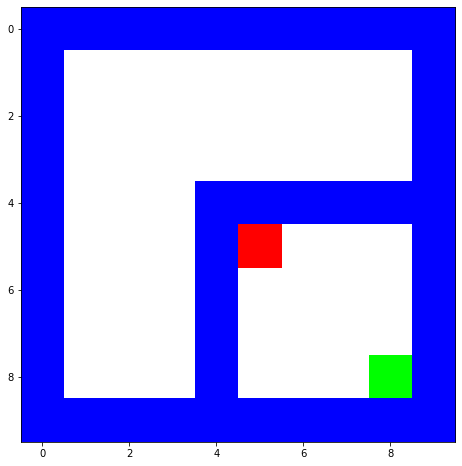

In [7]:
plt.imshow(img)

### 2. Use the environment creator thing to generate a list of steps

Note that if you want to change the default colours to creating an environment, you can read the `__init__` method of this class (this is NOT the colours we care about in the actual minigrid environment; this is just a mapping from the pixel art colours to the ordering of the adversarial env)

In [8]:
env_creator = AdversarialEnvCreator(debug=True)

In [9]:
adversarial_steps = env_creator(img)

Should be 3 channels:		 (10, 10, 3)
Should be of shape (h * w, 3):	 (100, 3)

Parsed pixels:
Goal loc:	 [88]
Agent loc:	 [55]
Wall loc:	 [ 0  1  2  3  4  5  6  7  8  9 10 19 20 29 30 39 40 44 45 46 47 48 49 50
 54 59 60 64 69 70 74 79 80 84 89 90 91 92 93 94 95 96 97 98 99]

Output:	 [88, 55, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 19, 20, 29, 30, 39, 40, 44, 45, 46, 47, 48, 49, 50, 54, 59, 60, 64, 69, 70, 74, 79, 80, 84, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [7]:
# This is the order that you will pass into the env.step_adversary(i) method.
# Note that this will automatically flatten the input 2d array into a 1D 
print(adversarial_steps)

[71, 111, 42, 43, 44, 45, 46, 47, 48, 55, 61, 68, 74, 81, 84, 85, 87, 94, 100, 107, 113, 120, 121, 122, 123, 124, 125, 126]


# Testing with Custom Multigrid

In [8]:
from custom_minigrid.envs import AdversarialEnv
import gym
import gym_minigrid

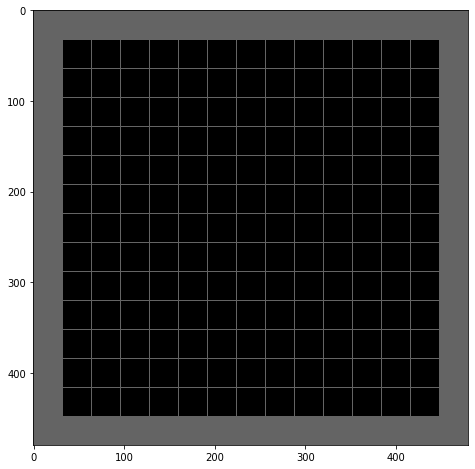

In [9]:
env = gym.make('MultiGrid-Adversarial-v0')
env.reset()
before_img = env.render('rgb_array')

plt.imshow(before_img);

In [10]:
env.reset()
env.step_adversary(adversarial_steps[0])
env.step_adversary(adversarial_steps[1])
for i in adversarial_steps[2:]:
    env.step_adversary(i)

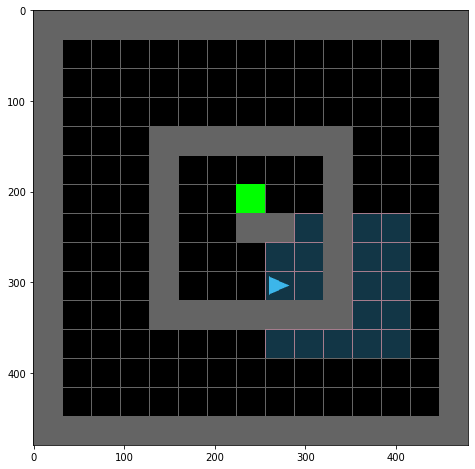

In [11]:
reset_img = env.render('rgb_array')
plt.imshow(reset_img);